#From Linear classifiers to SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





PARTICIPANTS: **(Fill in your names)**
    

In [3]:
!python -m pip install -U pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


In [5]:
!python -m pip install -U scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.5 MB/s eta 0:00:00


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

#Modules for image processing
import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

#Modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

#Useful for manual data splitting
import random
from sklearn.utils import shuffle


# 1. Loading and splitting data

**a)** Download the animals10classes dataset from hippocampus, which is a subset of the Caltech 101 dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html). The animals subset is composed of images belonging to one among 10 classes. Run the code bellow to check images and labels are read correctly and store the name of the classes in the list ```labelNamesAll```. If present after unziping the dataset, remove the _MACOSX directory as it is not needed.

In [4]:
# Uncomment if using COLAB  (and comment next cell)
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = ('/content/drive/MyDrive/DATA/animals10classes')


In [12]:
# Uncomment if running locally (comment if running in COLAB)
# Change with your own path
IMDIR = 'data/animals10classes'
# For Windows OS use IMIDR=r'/Users/dianamateus/DATA/101Caltech/animals10classes/'

In [13]:
#Keep4students
def loadImagesAndLabels(IMDIR):
  #This function glances through all subdirectories in IMDIR,
  #and creates a list of the subdirectory names, which will be
  #used as labels for all the images within.The function returns
  #the list of labels
  #
  #If the function returns an empty list, it is likely that IMDIR
  #is not defined correctly. In that case uncomment the lines below
  #to check the files that are actually being read.

  labelNamesAll = []

  for root, dirnames, filenames in os.walk(IMDIR):
      labelNamesAll.append(dirnames)
      #uncomment to check if the folder contains images
      for filename in filenames:
        f = os.path.join(root, filename)
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
           print(f)

  labelNamesAll = labelNamesAll[0]
  return labelNamesAll

#Call the function and
labelNamesAll=loadImagesAndLabels(IMDIR)
#print the list of all labels/subdirectories


data/animals10classes/ant/image_0032.jpg
data/animals10classes/ant/image_0026.jpg
data/animals10classes/ant/image_0027.jpg
data/animals10classes/ant/image_0033.jpg
data/animals10classes/ant/image_0019.jpg
data/animals10classes/ant/image_0025.jpg
data/animals10classes/ant/image_0031.jpg
data/animals10classes/ant/image_0030.jpg
data/animals10classes/ant/image_0024.jpg
data/animals10classes/ant/image_0018.jpg
data/animals10classes/ant/image_0020.jpg
data/animals10classes/ant/image_0034.jpg
data/animals10classes/ant/image_0008.jpg
data/animals10classes/ant/image_0009.jpg
data/animals10classes/ant/image_0035.jpg
data/animals10classes/ant/image_0021.jpg
data/animals10classes/ant/image_0037.jpg
data/animals10classes/ant/image_0023.jpg
data/animals10classes/ant/image_0022.jpg
data/animals10classes/ant/image_0036.jpg
data/animals10classes/ant/image_0042.jpg
data/animals10classes/ant/image_0040.jpg
data/animals10classes/ant/image_0041.jpg
data/animals10classes/ant/image_0013.jpg
data/animals10cl

**b).** Use the BuildDataset function to create a reduced dataset. In this notebook we will notably deal with binary classification problems. Print the sizes of the data matrix X and the label vector Y. Print as well the retained list of labels and the content of Y.

In [14]:
#Keep4students
def buildDataset (IMDIR,labelNamesAll,K=2,N=100,imHeight=100,imWidth=100,seed=50):
    #This function builds the data matrix from (a subset) of the label list.
    #Images are read using a composition of the path and the label list.
    #Parameters of this functions are:
    # K : the number of classes to consider
    # N : the maximum number of images to read from each category (the number
    #    of images per label is variable).
    # imHeight,imWidth: define the size of the target image. All read images
    #                  are resized to imHeight x imWidth
    # seed : fixes the random seed to be able to reproduce the results.
    # The function returns the data matrix X and the label vector Y.
    # Ideally, the X matrix will be of size (KxN)x(ImHeight x ImWidth) but
    # the number of rows will be less if the number of images in a given
    # category is smaller than N

    X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
    Y = -np.ones([K*N,1]) #label indices initiallized to -1
    labelNames = [] #list of retained categories

    random.seed(a=seed) #comment to make each run random

    globalCount = 0 #counts the actual number of images copied to the datamatrix

    # Iterate over the number of classes
    for i in range(K):
        #Randomly choose a new category
        while True:
            lab = random.randint(0,len(labelNamesAll)-1)
            if lab not in labelNames:
                break

        #define the path to read the images of the chosen label.
        #folders are named after the class label, print the chosen label
        filedir = os.path.join(IMDIR,labelNamesAll[lab])
        print('The chosen label ',i, ' is ',labelNamesAll[lab])
        print('It will be read in',filedir)

        #save the name of the class in labelNames
        labelNames.append(labelNamesAll[lab])

        #walk through the files of the label folder,
        #read images in grayscale and resize them
        #flatten the images to a vector
        #copy each image to one row of the data matrix
        #use classCount to retain at most N images per class
        #use globalCount to keep track of the total number of images
        classCount = 0
        for filename in os.listdir(filedir):
            f = os.path.join(filedir, filename)
            if f.endswith(('.jpg')) and (classCount < N):
                image = skimage.io.imread(f, as_gray=True)
                image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
                X[globalCount,:] = image.flatten()
                Y[globalCount,:] = i
                globalCount += 1
                classCount += 1

    #Remove the unused entries of X and Y
    print("Total number of samples",globalCount)
    X = X[:globalCount,:]
    Y = Y[:globalCount,:]

    return X,Y,labelNames

In [15]:
K=2
imHeight=100
imWidth=100

#Call the buildDataset function

X,Y,labelNames=buildDataset(IMDIR,labelNamesAll,K=2,N=100,imHeight=100,imWidth=100,seed=50)

#Check the built dataset classes
print("Used labels",labelNames)
print("Size of data matrix", X.shape)
print("Class labels", Y.T)

The chosen label  0  is  sea_horse
It will be read in data/animals10classes/sea_horse
The chosen label  1  is  crocodile
It will be read in data/animals10classes/crocodile
Total number of samples 107
Used labels ['sea_horse', 'crocodile']
Size of data matrix (107, 10000)
Class labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


**c)** Split the dataset into a train (80% of samples) and a test set (20% samples) subsets. Make sure the data are shuffled before the split, such that the proportion of the two classes is similar in the train and test.

In [58]:
#PUT your code here, and check the obtained matrices
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42, shuffle=True)
print("size of train dataset",X_train.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("test target vector",Y_test.T)

size of train dataset (85, 10000)
size of test dataset (22, 10000)
train target vector [[1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.
  1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1.]]
test target vector [[1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]]


**a) Linear SVM** Create an SVC model with a linear kernel and default values ``svmLin=SVC(kernel='linear')``.

* Fit the SVC on the training dataset and make predictions on the test set.

* Print the vector of ground truth values and the vector of predictions.
* Compute  the number of errors made.
* Run the SVC.score() function.
* Activate probabilities ``svmLin = SVC(kernel='linear',probability=True)``.
* Make probabilistic predictions ``svmLin.predict_proba``

* **QUESTIONS**
  * Is it necessary to normalize the features before training?
    * Yes,it is necessary to normalise features. Because the range of the values of every feature varies differently.
  * Which metric is being computed by SVC.score()
    * TP/(TP+TN) Accuracy
  * How are the probabilistic predictions computed? (check the documentation)
    * Shown below.

In [59]:
# Create, train and test an svm model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svmLin=SVC(kernel='linear', probability=True)
svm_pipeline = make_pipeline(StandardScaler(), svmLin)
svm_pipeline.fit(X_train, Y_train)
print("Train data score: ", svm_pipeline.named_steps['svc'].score(X_train, Y_train))
print("Test data score: ", svm_pipeline.named_steps['svc'].score(X_test, Y_test))
# Create, train and test a "probabilistic" SVM model
# svmLin = SVC(kernel='linear',probability=True)
# clf = make_pipeline(StandardScaler(), svmLin)
# clf.fit(X_train, Y_train)
# clf.score(X_test, Y_test)
# svmLin.predict_proba(X_train)
Y_pred_train=svm_pipeline.predict(X_train)
Y_pred_test=svm_pipeline.predict(X_test)

train_probabilities = svm_pipeline.predict_proba(X_train)
print(f"Train Probabilities: {train_probabilities[:5]}")

/opt/anaconda3/envs/envs/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train data score:  1.0
Test data score:  0.36363636363636365
Train Probabilities: [[0.35352433 0.64647567]
 [0.71829898 0.28170102]
 [0.71826295 0.28173705]
 [0.71822271 0.28177729]
 [0.7182861  0.2817139 ]]


In [60]:
support_vectors = svm_pipeline.named_steps['svc'].support_vectors_
num_support_vectors = len(svm_pipeline.named_steps['svc'].support_)
print(f"Number of support vectors: {num_support_vectors}")

Number of support vectors: 73


In [61]:
print("w: ",svmLin.coef_.shape)
print("b: ", svmLin.intercept_.shape)

w:  (1, 10000)
b:  (1,)


**b) Support vectors**
* By looking at the dimensions of the data matrix, how many parameters does the **model** have? (Hint: the answer is not SVC.get_params())
    * Total 10001. Since sign of (w.x+b) gives dicision of classfiction where w is the paramter matrix and X_train has size of (85, 10000) mentioned above. Therefore total w will be (1, 10000) and 1 parameter from cofficient b.
* How many hyperparameters does the model have?
    * For a linear SVM, the main hyperparameter is C. Only 1 is required but we can also include kernel, gamma .... 
* How many support vectors?
    * 73, given above.
* Check the SVC class attributes https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html and identify the learnable parameters, the support vectors and the dual variables
* Display the support vectors
    * Displyed in Figure named support vecors.
* Relying on the lecture, compute the model parameters from the dual coefficients. Verify the obtained result corresponds to the estimated parameters.
    * Given answer below.



In [62]:
support_vectors.shape

(73, 10000)

In [63]:
dual_coefficients =  svm_pipeline.named_steps['svc'].dual_coef_
print("Dual Coefficients:\n", dual_coefficients)

intercept =svm_pipeline.named_steps['svc'].intercept_
print("Intercept (b):", intercept)

Dual Coefficients:
 [[-3.24413813e-04 -6.53393009e-05 -4.88812005e-05 -5.75665515e-05
  -3.09196072e-04 -4.68707751e-05 -7.62039418e-04 -4.10066934e-04
  -2.62611452e-04 -6.36357092e-04 -1.85331548e-04 -3.27132217e-04
  -6.39851736e-04 -8.52781234e-04 -3.19745817e-04 -2.44118826e-04
  -5.58997653e-06 -1.54926316e-03 -1.72671909e-04 -5.31806162e-04
  -4.91980016e-04 -2.51839598e-04 -7.01631784e-05 -1.11986956e-04
  -4.59893918e-05 -1.34527425e-04 -7.88723639e-04 -3.30942479e-04
  -3.35091963e-04 -1.76981281e-04 -6.62486186e-05 -4.61105713e-04
  -1.52294819e-04 -1.03544001e-04 -7.44294377e-04 -4.79127265e-04
  -5.76534309e-04 -1.52751282e-04 -1.49066772e-03  5.30621525e-04
   4.15994064e-04  6.77280628e-04  1.42111172e-03  1.49262483e-06
   2.86399070e-04  8.83381318e-04  5.71694981e-04  5.98832963e-04
   6.27412189e-05  1.62252425e-04  4.56530812e-04  7.42366231e-04
   2.26159620e-04  2.59904746e-04  9.08816317e-05  1.31812266e-04
   4.36863538e-04  2.12529362e-04  4.63646074e-05  3.808

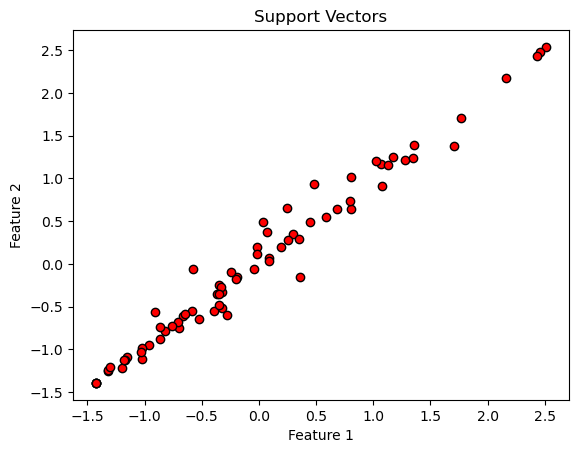

In [64]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], edgecolors='k', c='r', marker='o')
plt.title("Support Vectors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [65]:
computed_w = np.dot(dual_coefficients, support_vectors)
print("Computed w:", computed_w)

model_w = svmLin.coef_
print("Model w:", model_w)

assert np.allclose(computed_w, model_w), "Computed w does not match model's coef_"
print("Verification successful: Computed w matches model's coef_")

Computed w: [[-0.00044948 -0.00120905 -0.00030221 ...  0.00172112  0.00166214
   0.00177967]]
Model w: [[-0.00044948 -0.00120905 -0.00030221 ...  0.00172112  0.00166214
   0.00177967]]
Verification successful: Computed w matches model's coef_


**c) Kernel SVMs.**
* Train three additional SVC models each using one among the kernel functions:
```
'kernel': ['rbf','poly', 'sigmoid'],
```
keep all other parameters to their default value.

* Report the number of support vectors found after fitting for each Kernel
* What are the hyperparameters available in each case?
* Report the number of errors and the accuracy for each model

In [71]:
# Define kernels to test
kernels = ['rbf', 'poly', 'sigmoid']

# Dictionary to store results
results = {}

for kernel in kernels:
    print(f"\nTraining SVC with {kernel} kernel...")
    
    # Create and train the model
    svc = SVC(kernel=kernel)
    pipeline = make_pipeline(StandardScaler(), svc)
    pipeline.fit(X_train, Y_train)
    
    # Support vectors
    support_vectors = svc.support_vectors_
    n_support_vectors = len(svc.support_)
    
    # # Errors and accuracy
    Y_train_pred = pipeline.predict(X_train)
    Y_test_pred = pipeline.predict(X_test)
    
    train_errors = sum(Y_train != Y_train_pred)
    test_errors = sum(Y_test != Y_test_pred)
    
    train_accuracy = svc.score(Y_train, Y_train_pred)
    test_accuracy = svc.score(Y_test, Y_test_pred)
    
    # # Available hyperparameters
    # hyperparameters = svc.get_params().keys()
    
    # # Store results
    # results[kernel] = {
    #     "n_support_vectors": n_support_vectors,
    #     "train_errors": train_errors,
    #     "test_errors": test_errors,
    #     "train_accuracy": train_accuracy,
    #     "test_accuracy": test_accuracy,
    #     "hyperparameters": hyperparameters
    # }

# Display results
# import pandas as pd
# results_df = pd.DataFrame(results).T
# results_df["hyperparameters"] = results_df["hyperparameters"].apply(lambda x: list(x))
# results_df.drop(columns=["hyperparameters"], inplace=True)  # Optional: Drop hyperparameter details
# import ace_tools as tools; tools.display_dataframe_to_user(name="SVC Kernel Results", dataframe=results_df)



Training SVC with rbf kernel...


/opt/anaconda3/envs/envs/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: X has 1 features, but SVC is expecting 10000 features as input.

**d)Hyperparameter tuning**
Tune the hyperparameters of both the linear and the non-linear SVMs using a crossvalidation strategy. Resplit the training set into training and validation or use the ``GridSearchCV`` functionality from sklearn. In the later case  EXPLAIN how the dataset was and the criteria used to retain a given set of hyperparameters



In [45]:
# Some values for reference, you might change this for improved results
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'degree': [2, 3, 5]}
search = GridSearchCV(clf, param_grid, cv=5)
search.fit(X_train,Y_train)

ValueError: Invalid parameter 'C' for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))]). Valid parameters are: ['memory', 'steps', 'verbose'].

## 3. PERFORMANCE MEASURES
**a) Fill in the function bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix values TP, TN, FP, FN

You can use the code bellow as guide or define your own functions

**Hint:** Add a numerical zero eps to the denominators to prevent dividing by zero

Compare your results vs the in-built sklearn measures:
```from sklearn.metrics import classification_report```

In [15]:
# Functions to compute the errors between prediction and ground truth

def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_gt)

    eps = 1e-12

    # True positives TP
    TP = Y_pred[Y_gt==1]

    # True negatives TN
    TN =

    # False positives FP
    FP =

    # False negatives FN
    FN =

    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN


    # Accuracy
    measures['accuracy'] =

    # Precision
    measures['precision'] =

    # Specificity
    measures['specificity']=

    # Recall
    measures['recall'] =

    # F-measure
    measures['f1'] =

    # Negative Predictive Value
    measures['npv'] =

    # False Positive Rate
    measures['fpr'] =

    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n')

    return measures




SyntaxError: invalid syntax (1115052590.py, line 10)

**b) ROC curves**
- Plot the ROC curves of all the trained svm models (with different kernels including linear) before and after the hyperparameter tuning. Comment the results
- Compare the roc curves of the best obtained models for each kernel between.
- Add a curve for a  logistic regression model.

You might use your own thresholding function or use the ``roc_curve`` functionality from scikit learn

Hint: To threshold we need to make probabilistic predictions

In [ ]:
# Fit a logistic regression model here and make probabilistic predictions

In [ ]:
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for logistic regression
fpr, tpr, _ = roc_curve(Y_test, Y_pred_logreg_probas[:,1])
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()



**c) Qualitative Results** Using your best model, show some of the test images and write on the title the predictions vs the ground truth labels

In [ ]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]

#Change your predictions vector here
Y_best=Y_rbfBest

fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth))

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_best.ravel()[i].astype(int)]
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()


**d) REPORT:** Starting from the best model, analyse and discuss the behaviour for different SVC hyperparameters, choice of classes, and numbers of images in each class.
